In [1]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import subprocess
import json
import os
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.externals import joblib
from plotting import plot_confusion_matrix, plot_roc, plot_scores, plot_precision_recall, plot_feature_importance, plot_information_gain
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
from baseline import BASELINE_FEATURE_COLUMNS
import warnings
warnings.filterwarnings(action='once')

/Users/falco/.local/share/virtualenvs/vandalism-classifier-YnBQ-UjL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/falco/.local/share/virtualenvs/vandalism-classifier-YnBQ-UjL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/falco/.local/share/virtualenvs/vandalism-classifier-YnBQ-UjL/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import dataset
df = pd.read_csv('./data/features-0c25f9f.csv', index_col='revision_id')
tag_df = pd.read_csv('./data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,...,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,hasNumericOutlierInChangedCellValues,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.0,-1.0,-1.0,...,34.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,1.0,25.0,25.0,...,0.0,1.0,0.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.0,7837.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.0,2108.0,-1.0,...,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,0.0,4077.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


/Users/falco/.local/share/virtualenvs/vandalism-classifier-YnBQ-UjL/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


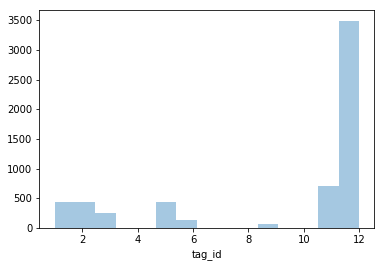

In [3]:
# Tag distribution
sns.distplot(df['tag_id'], kde=False)
plt.show()

---
## Preprocessing

In [4]:
def preprocessing(features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'], tags=['all vandalism', 1, 2, 3, 5, 6, 9, 11, 12])
display(widget)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Dropdown(des…

Feature config: all , Features after preprocessing: 122


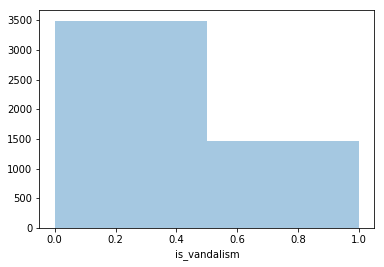

In [5]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))

# TODO: REMOVE!!!!
processed_df = processed_df.fillna(0)

sns.distplot(processed_df['is_vandalism'].map(lambda x: 1 if x else 0), kde=False,  bins=2)
plt.show()

In [6]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [7]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3720, 121)
y train (3720,)
X test (1240, 121)
y test (1240,)


---
## Grid search model parameters

In [8]:
# Grid search model params
# 'class_weight': ['balanced', {0:1,1:1}, {0:2,1:1}, {0:4,1:1}, {0:6,1:1}, {0:8,1:1}, {0:10,1:1}, {0:20,1:1}]
parameters = [{
    'n_estimators': [300], 
    'class_weight': ['balanced']
}]

grid_search = GridSearchCV(RandomForestClassifier(),
                           parameters, 
                           scoring=['f1', 'precision', 'recall', 'roc_auc'],
                           refit='f1',
                           cv=10,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

params = grid_search.best_params_
print('Best params', grid_search.best_params_)
print('Best score', grid_search.best_score_)

Best params {'class_weight': 'balanced', 'n_estimators': 300}
Best score 0.6317311743514923


---
## Train: Cross evaluate model using best parameters

In [9]:
# Train scores & predictions
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
train_scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=10, n_jobs=-1, return_train_score=False)

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
y_train_predict_proba = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

Cross validation scores


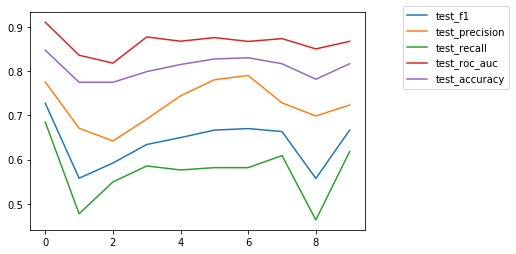

In [10]:
plot_scores(train_scores)

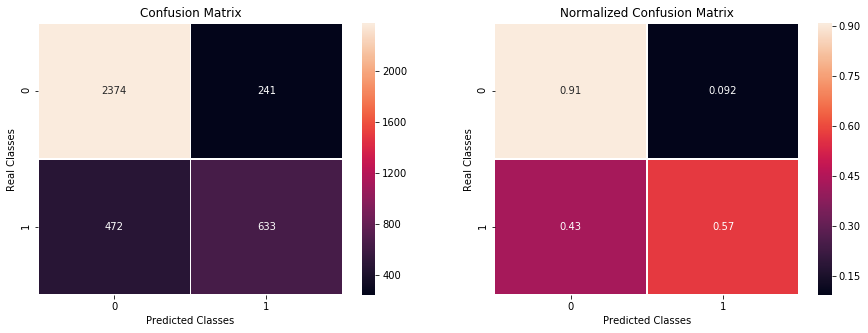

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.83      0.91      0.87      2615
   Vandalism       0.72      0.57      0.64      1105

 avg / total       0.80      0.81      0.80      3720



In [11]:
plot_confusion_matrix(y_train, y_train_predict)

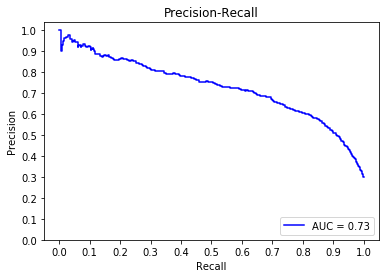

In [12]:
plot_precision_recall(y_train, y_train_predict_proba[:, 1])

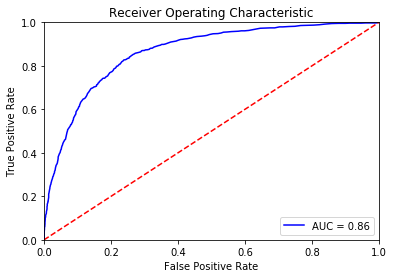

Receiver Operation Characteristic AUC 0.8642527015218501


In [13]:
plot_roc(y_train, y_train_predict_proba[:, 1])

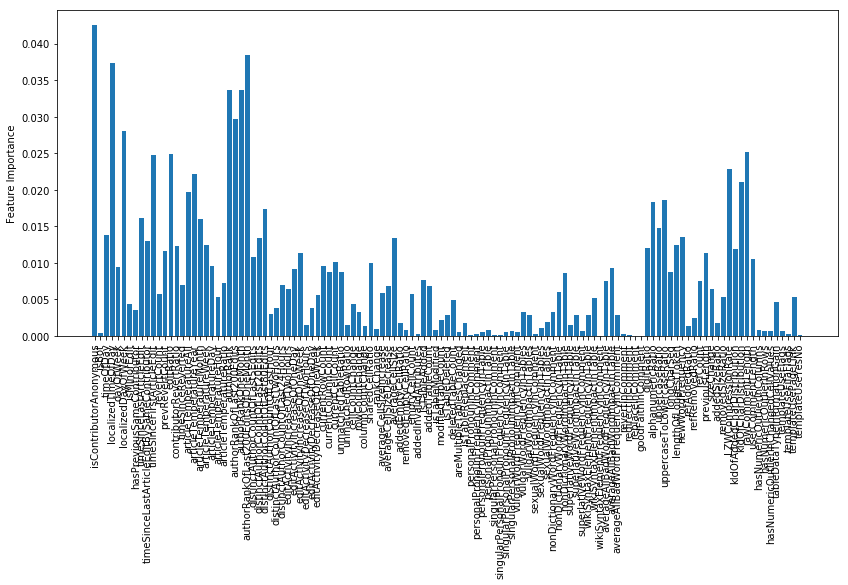

In [14]:
# Feature importance
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
clf.fit(X_train, y_train)
train_feature_importance = plot_feature_importance(clf, X_train.columns)

---
## Test: Test model on final test dataset

In [15]:
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [16]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

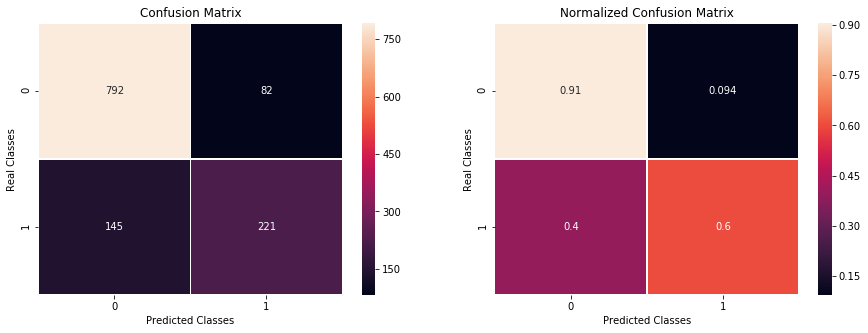

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.85      0.91      0.87       874
   Vandalism       0.73      0.60      0.66       366

 avg / total       0.81      0.82      0.81      1240



In [17]:
plot_confusion_matrix(y_test, y_test_predict)

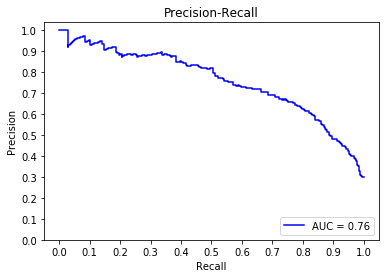

In [18]:
plot_precision_recall(y_test, y_test_predict_proba[:, 1])

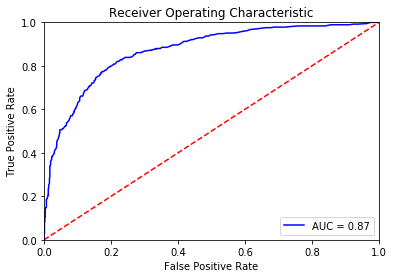

Receiver Operation Characteristic AUC 0.8701513673706719


In [19]:
plot_roc(y_test, y_test_predict_proba[:, 1])

In [20]:
# False positives for the test set
fp_test = X_test[(y_test == 0) & (y_test_predict == 1)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']].head(10)

,tag_id
revision_id,
10684846,12
21168875,12
46323645,12
68816395,12
96696678,12
100098236,12
128508486,12
147138016,12
156298623,12


In [21]:
# False negatives for the test set
fp_test = X_test[(y_test == 1) & (y_test_predict == 0)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']].head(20)

,tag_id
revision_id,
30637307,3
45985022,2
45985022,11
45985022,5
47773679,1
47773679,11
47773679,3
53860430,1
53860430,2


In [22]:
# Inspect revision
@interact(revision_id='', label=X.columns)
def show_revision(revision_id, label):
    if len(revision_id) > 1:
        print(df.loc[int(revision_id)][['tag_id', label]])

interactive(children=(Text(value='', description='revision_id'), Dropdown(description='label', options=('isCon…

In [23]:
# Feature histogramm
@interact(label=X.columns)
def show_feature_per_tag(label):
    sns.jointplot(x='tag_id', y=label, data=df)
    plt.show()
    print('Revisions with highest values')
    print(df.sort_values([label], ascending=[False])[['tag_id', label]].head(10))

interactive(children=(Dropdown(description='label', options=('isContributorAnonymous', 'isBot', 'timeOfDay', '…

# Information Gain 

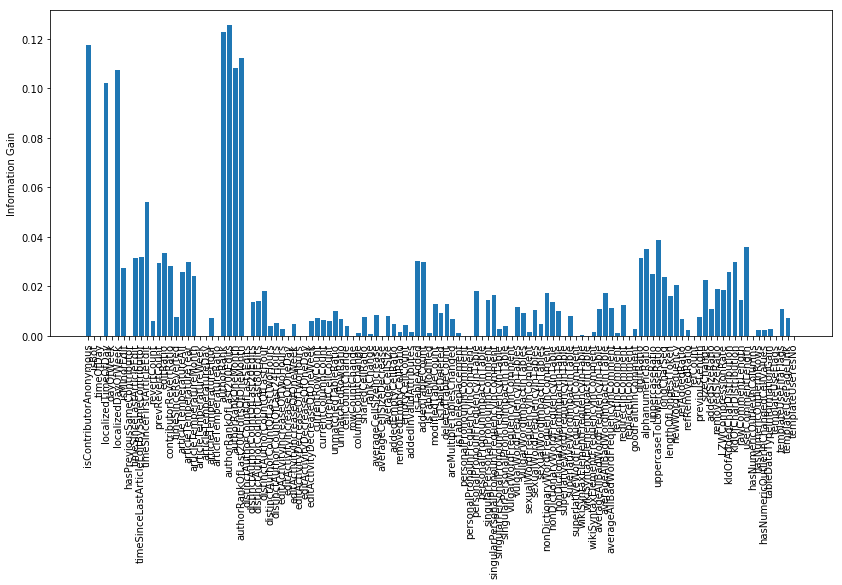

In [38]:
ig = plot_information_gain(X, y)

In [79]:
from IPython.display import display

info_gain = pd.DataFrame({
    'feature': X.columns,
    'gain': ig,
    'importance': train_feature_importance
})

info_gain.sort_values(['gain'], ascending=False, inplace=True)

importance = info_gain.sort_values(['importance'], ascending=False)

def info_gain_of(features):
    return info_gain[info_gain.feature.isin(features)][['feature', 'gain']]

def importance_of(features):
    return importance[importance.feature.isin(features)][['feature', 'importance']]
    
def check(features):
    check_gain = info_gain_of(features)
    check_importance = importance_of(features)
    display(check_gain)
    display(check_importance)

## User Features

In [80]:
user_features = [
    'isContributorAnonymous',
    'isBot'
]

check(user_features)

,feature,gain
0,isContributorAnonymous,0.117287
1,isBot,0.000000


,feature,importance
0,isContributorAnonymous,0.042498
1,isBot,0.000382


## Edit Features

In [81]:
edit_features = [
    'timeOfDay',
    'localizedTimeOfDay',
    'dayOfWeek',
    'localizedDayOfWeek',
    'isMinorEdit'
]

check(edit_features)

,feature,gain
5,localizedDayOfWeek,0.107197
3,localizedTimeOfDay,0.102004
6,isMinorEdit,0.027489
4,dayOfWeek,0.000000
2,timeOfDay,0.000000


,feature,importance
3,localizedTimeOfDay,0.037311
5,localizedDayOfWeek,0.028099
2,timeOfDay,0.013813
4,dayOfWeek,0.009369
6,isMinorEdit,0.004353


## Page Features

In [82]:
page_features = [
    'hasPreviousSameContributor',
	'timeSinceLastArticleEdit',
	'timeSinceLastArticleEditBySameContributor',
	'timeSinceFirstArticleEdit',
	'revertCount',
	'prevRevertCount',
	'editRatio',
	'contributorRevertRatio',
	'timeSinceReverted',
	'articleTemperatureAll',
	'articleTemperatureYear',
	'articleTemperatureMonth',
	'articleTemperatureWeek',
	'articleTemperatureDay',
	'articleTemperatureHour',
	'articleTemperatureRatio',
	'authorRank',
	'authorRankOfLast200Edits',
	'authorRankOneMonth',
	'authorRankOfLast200EditsOfOneMonth',
	'distinctAuthorCountOfLast5Edits',
	'distinctAuthorCountOfLast20Edits',
	'distinctAuthorCountOfLast80Edits',
	'distinctAuthorCountOfLastHour',
	'distinctAuthorCountOfLastTwoHours',
	'distinctAuthorCountOfLast24Hours',
	'editActivityIncreaseOfTwoHours',
	'editActivityIncreaseOfOneDay',
	'editActivityIncreaseOfOneWeek',
	'editActivityDecreaseOfTwoHours',
	'editActivityDecreaseOfOneDay',
	'editActivityDecreaseOfOneWeek',
]

check(page_features)

,feature,gain
24,authorRankOfLast200Edits,0.125395
23,authorRank,0.122513
26,authorRankOfLast200EditsOfOneMonth,0.112064
25,authorRankOneMonth,0.108020
10,timeSinceFirstArticleEdit,0.054109
13,editRatio,0.033503
9,timeSinceLastArticleEditBySameContributor,0.031838
8,timeSinceLastArticleEdit,0.031340
17,articleTemperatureYear,0.029920
12,prevRevertCount,0.029588


,feature,importance
26,authorRankOfLast200EditsOfOneMonth,0.038372
23,authorRank,0.033605
25,authorRankOneMonth,0.033591
24,authorRankOfLast200Edits,0.029672
13,editRatio,0.024839
10,timeSinceFirstArticleEdit,0.024711
17,articleTemperatureYear,0.022208
16,articleTemperatureAll,0.019754
29,distinctAuthorCountOfLast80Edits,0.017430
8,timeSinceLastArticleEdit,0.016143


## Table Features

In [83]:
table_features = [
    'currentRowCount',
    'currentColumnCount',
    'currentCellCount',
    'unmatchedTableRatio',
    'unmatchedRowRatio',
    'cellCountChange',
    'rowCountChange',
    'columnCountChange',
    'sharedCellRatio',
    'rankChange',
    'averageCellSizeIncrease',
    'averageCellSizeDecrease',
    'averageCellSize',
    'addedEmptyCellRatio',
    'removedEmptyCellRatio',
    'emptyCellCount',
    'addedInvalidAttributes',
    'isTableAdded',
    'addedTableCount',
    'isTableModified',
    'modifiedTableCount',
    'isTableDeleted',
    'deletedTableCount',
    'areMultipleTablesChanged',
    'isTableReplacement',
    'hasNumericOutlierInColumns',
    'hasNumericOutlierInRows',
    'hasNumericOutlierInChangedCellValues',
    'tableDataTypeInformationGain',
]

check(table_features)

,feature,gain
56,isTableAdded,0.030060
57,addedTableCount,0.029726
59,modifiedTableCount,0.013060
61,deletedTableCount,0.012904
42,unmatchedTableRatio,0.010160
60,isTableDeleted,0.009223
49,averageCellSizeIncrease,0.008298
51,averageCellSize,0.007885
47,sharedCellRatio,0.007787
39,currentRowCount,0.007068


,feature,importance
51,averageCellSize,0.013416
41,currentCellCount,0.010178
47,sharedCellRatio,0.010002
39,currentRowCount,0.009539
42,unmatchedTableRatio,0.008777
40,currentColumnCount,0.008691
56,isTableAdded,0.007608
50,averageCellSizeDecrease,0.006876
57,addedTableCount,0.006768
49,averageCellSizeIncrease,0.005895


## Language

In [84]:
language_features = [
    'personalPronounInComment',
    'personalPronounFrequencyInComment',
    'personalPronounFrequencyInTable',
    'personalPronounImpactInTable',
    'singularPersonalPronounInComment',
    'singularPersonalPronounFrequencyInComment',
    'singularPersonalPronounFrequencyInTable',
    'singularPersonalPronounImpactInTable',
    'vulgarWordFrequencyInComment',
    'vulgarWordFrequencyInTables',
    'vulgarWordImpactInTables',
    'sexualWordFrequencyInComment',
    'sexualWordFrequencyInTables',
    'sexualWordImpactInTables',
    'nonDictionaryWordFrequencyInComment',
    'nonDictionaryWordFrequencyInTable',
    'nonDictionaryWordImpactInTable',
    'superlativeWordFrequencyInTable',
    'superlativeWordImpactInTable',
    'superlativeWordFrequencyInComment',
    'wikiSyntaxElementFrequencyInTable',
    'wikiSyntaxElementImpactInTable',
    'wikiSyntaxElementFrequencyInComment',
    'averageAllBadWordFrequencyInTable',
    'averageAllBadWordImpactInTable',
    'averageAllBadWordFrequencyInComment',
    'revertInComment',
    'redirectInComment',
    'replaceInComment',
    'goodFaithInComment',
]

check(language_features)

,feature,gain
66,personalPronounFrequencyInTable,0.017997
88,averageAllBadWordImpactInTable,0.017524
78,nonDictionaryWordFrequencyInComment,0.017510
69,singularPersonalPronounFrequencyInComment,0.016504
68,singularPersonalPronounInComment,0.014599
79,nonDictionaryWordFrequencyInTable,0.013731
91,redirectInComment,0.012648
73,vulgarWordFrequencyInTables,0.011639
89,averageAllBadWordFrequencyInComment,0.011474
87,averageAllBadWordFrequencyInTable,0.010794


,feature,importance
88,averageAllBadWordImpactInTable,0.009269
80,nonDictionaryWordImpactInTable,0.008628
87,averageAllBadWordFrequencyInTable,0.007479
79,nonDictionaryWordFrequencyInTable,0.006051
85,wikiSyntaxElementImpactInTable,0.005161
78,nonDictionaryWordFrequencyInComment,0.003320
73,vulgarWordFrequencyInTables,0.003258
82,superlativeWordImpactInTable,0.002929
89,averageAllBadWordFrequencyInComment,0.002920
74,vulgarWordImpactInTables,0.002902


## Text Features

In [85]:
text_features = [
    'digitRatio',
    'alphanumericRatio',
    'uppercaseRatio',
    'uppercaseToLowercaseRatio',
    'longCharSeq',
    'lengthOfLongestToken',
    'newWordFrequency',
    'refAddedRatio',
    'refRemovedRatio',
    'refCount',
    'templateUseFlags',
    'templateUseFifaFlags',
    'templateUsePageLink',
    'templateUseYesNo'
]

check(text_features)

,feature,gain
97,uppercaseToLowercaseRatio,0.038643
95,alphanumericRatio,0.035085
94,digitRatio,0.031276
96,uppercaseRatio,0.025095
98,longCharSeq,0.023675
100,newWordFrequency,0.020471
99,lengthOfLongestToken,0.016203
118,templateUseFifaFlags,0.011037
119,templateUsePageLink,0.007298
101,refAddedRatio,0.006641


,feature,importance
97,uppercaseToLowercaseRatio,0.018622
95,alphanumericRatio,0.018326
96,uppercaseRatio,0.014796
100,newWordFrequency,0.013533
99,lengthOfLongestToken,0.012463
94,digitRatio,0.012093
98,longCharSeq,0.008744
103,refCount,0.007579
119,templateUsePageLink,0.005364
102,refRemovedRatio,0.002414


## Byte Features

In [86]:
byte_features = [
    'previousLength',
    'sizeChange',
    'addedSizeRatio',
    'removedSizeRatio',
    'LZWCompressionRate',
    'kldOfAddedCharDistribution',
    'kldOfCharDistribution',
    'rawCommentLength',
    'userCommentLength'
]

check(byte_features)

,feature,gain
112,userCommentLength,0.035985
110,kldOfCharDistribution,0.029826
109,kldOfAddedCharDistribution,0.025870
105,sizeChange,0.022627
107,removedSizeRatio,0.018802
108,LZWCompressionRate,0.018539
111,rawCommentLength,0.014471
106,addedSizeRatio,0.011043
104,previousLength,0.007584


,feature,importance
111,rawCommentLength,0.025186
108,LZWCompressionRate,0.022890
110,kldOfCharDistribution,0.021048
109,kldOfAddedCharDistribution,0.011919
104,previousLength,0.011330
112,userCommentLength,0.010514
105,sizeChange,0.006353
107,removedSizeRatio,0.005334
106,addedSizeRatio,0.001738


In [87]:
f = []
f.extend(user_features)
f.extend(page_features)
f.extend(edit_features)
f.extend(table_features)
f.extend(language_features)
f.extend(byte_features)
f.extend(text_features)
assert set(f) == set(X.columns)